In [2]:
from collections import Counter
import re
import json
import pickle
from multiprocessing import Pool

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn
from scipy.sparse import csr_matrix, csc_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, auc, precision_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Prep the data

In [31]:
m1 = re.compile('\(.*\)')
m2 = re.compile('\s+')

def text_prepping(ingredient):
    ingredient = ingredient.replace(',', ';')
    ingredient = m1.sub('', ingredient)
    ingredient = m2.sub(' ', ingredient).strip()
    
    return ingredient

def data_json_to_dict():

    train_data = json.load(open('data/train.json','r'))
    test_data = json.load(open('data/test.json','r'))

    # do some text clening first
    ingredients = set()
    for i in train_data:
        for j in range(len(i['ingredients'])):
            i['ingredients'][j] = text_prepping(i['ingredients'][j])
            ingredients.add(i['ingredients'][j])
    for i in test_data:
        for j in range(len(i['ingredients'])):
            i['ingredients'][j] = text_prepping(i['ingredients'][j])
            ingredients.add(i['ingredients'][j])
    
    ingredients = list(ingredients)
    data = {}
    for i in train_data:
        data[i['id']] = {'cuisine':i['cuisine']}
        for ingredient in ingredients:
            data[i['id']][ingredient] = 1 if ingredient in i['ingredients'] else 0
            
    return ingredients, data

def write_csv(ingredients, data):
    fout = open('./data/data.csv', 'w')
    fout.write('cuisine,' + ','.join(ingredients) + '\n')
    for i, recipe in data.items():
        if recipe['cuisine'] == '':
            continue    
        fout.write('{},{}\n'.format(recipe['cuisine'], ','.join([str(recipe[i]) for i in ingredients])))
    fout.close()

#ingredients, recipes = data_json_to_dict()
write_csv(ingredients, recipes)


In [2]:
def load_data():
    data = pd.read_csv('./data/data.csv')
    ingredients = data.columns.tolist()
    ingredients.remove('cuisine')

    X = data[ingredients]
    y = data['cuisine']

    lbl_enc = LabelEncoder()
    y_fit = lbl_enc.fit(y)
    labels = list(set(y))
    labels_map = y_fit.transform(np.array(labels))
    labels_map = dict(zip(labels_map, labels))

    y = y_fit.transform(y)
    
    return X, y, data['cuisine'], ingredients, labels_map

In [53]:
X, y, cuisines, ingredients, labels_map = load_data()

In [54]:
X = X.loc[:,X.sum(axis=0)>0]
X.shape

(39774, 6704)

In [8]:
open('ingredients.csv', 'w').write('\n'.join(ingredients))

117623

# Some basic ranking and stats on the data

In [13]:
cuisines.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [14]:
tmp = X.sum(axis=0)
tmp = tmp[tmp>0]
tmp.sort_values(ascending=False)

salt                                    18048
onions                                   7972
olive oil                                7971
water                                    7457
garlic                                   7380
sugar                                    6434
garlic cloves                            6236
butter                                   4847
ground black pepper                      4784
all-purpose flour                        4632
pepper                                   4438
vegetable oil                            4385
eggs                                     3388
soy sauce                                3296
kosher salt                              3113
green onions                             3078
tomatoes                                 3058
large eggs                               2948
carrots                                  2814
unsalted butter                          2782
ground cumin                             2747
extra-virgin olive oil            

## Some histograms

#### Tally ingredients

In [11]:
tmp = X.sum(axis=0)

fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(tmp, 100)
plt.xlabel('Number of recipes an ingredient is in.')
plt.ylabel('Count')

tmp[tmp>100]=100
plt.subplot(1, 2, 2)
plt.hist(tmp, 100)
plt.xlabel('Number of recipes an ingredient is in (max=100).')
plt.ylabel('Count')

plt.tight_layout()
plt.rcParams["font.size"] = "16"
plt.savefig('./plots/hist-ingredient-count.png')
plt.close()

#### Tally the cuisines

In [15]:
tmp = Counter(y)

plt.hist(tmp.values())
plt.xlabel('N of cuisine type')
plt.savefig('./plots/hist-cuisine-count.png')
plt.close()

# Unsupervised stuff

### t-SNE

In [20]:
def plot_tsne(X, y, label_map, filename, perplexity):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    X_t = tsne.fit_transform(X)

    cmap = plt.get_cmap('Paired')
    cuisines = list(set(y))
    tmp = np.arange(0,1,1/(float(len(cuisines))+1))[1:]

    fig, ax = plt.subplots(figsize=(15,10))
    for i in range(len(tmp)):
        tsne_tmp = X_t[y==cuisines[i]]
        ax.scatter(tsne_tmp[:,0],tsne_tmp[:,1],color=cmap(tmp[i]),label=str(label_map[cuisines[i]]),s=4)
        
        x0 = np.median(tsne_tmp[:,0])
        x1 = np.median(tsne_tmp[:,1])

        ax.text(x0, x1, str(label_map[cuisines[i]]), weight='bold')

    plt.legend(bbox_to_anchor=(1, 0.5),ncol=2)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    plt.clf()


In [17]:
def plot_tsne_pool(params):
    X, y, cuisines, ingredients, labels_map = load_data()
    
    plot_tsne(
        X[0:params[0]],
        y[0:params[0]],
        labels_map,
        params[1],
        params[2])

In [22]:
pool = Pool(5)

params = []
for perplexity in [2, 5, 30, 50, 100]:
    filename = './plots/tsne-perplexity{}.png'.format(perplexity)
    params.append([10000, filename, perplexity])

pool.map(plot_tsne_pool, params)

[None, None, None, None, None]

### PCA

In [24]:
def plot_pca(X, y, labels_map, filename):
    pca = PCA(n_components=2)
    pca.fit(X.T)

    cmap = plt.get_cmap('Paired')
    cuisines = list(set(y))
    tmp = np.arange(0,1,1/(float(len(cuisines))+1))[1:]

    fig, ax = plt.subplots(figsize=(15,10))
    for i in range(len(tmp)):
        pca_tmp = pca.components_.T[y==cuisines[i],:]
        ax.scatter(pca_tmp[:,0],pca_tmp[:,1],color=cmap(tmp[i]), label=str(labels_map[cuisines[i]]),s=4)

    plt.legend(bbox_to_anchor=(1, 0.5),ncol=2)
    plt.tight_layout()
    plt.savefig(filename)

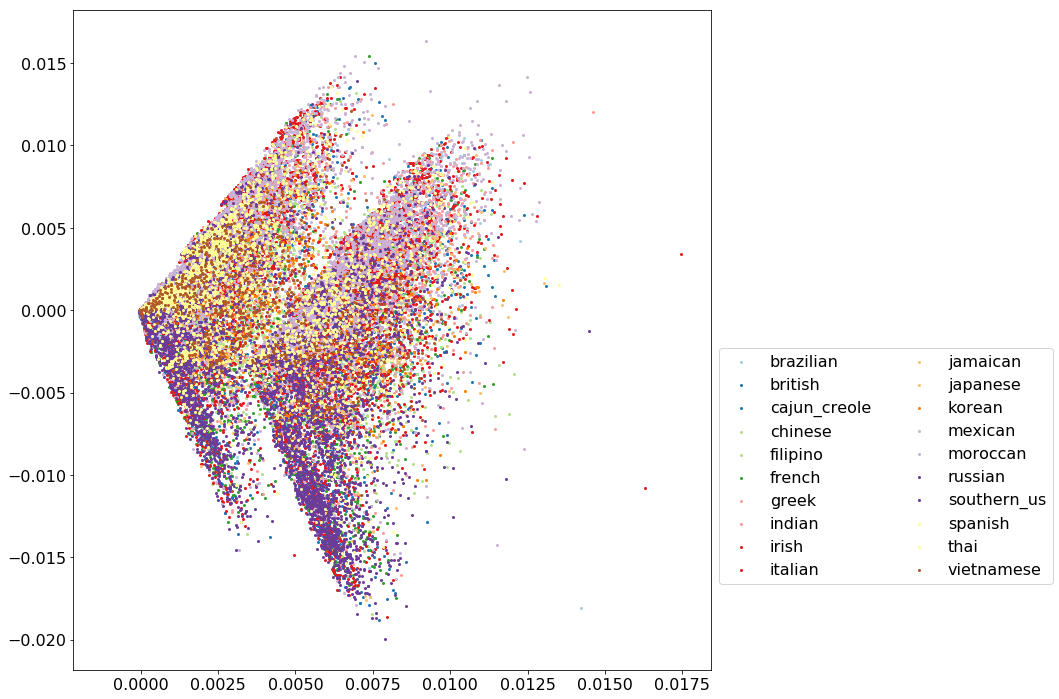

In [25]:
plot_pca(X, y, labels_map, './plots/PCA.png')

# Models

In [5]:
def plot_scores(grid_search, param, xlab, filename):
    
    params = [i[param] for i in grid_search.cv_results_['params']]
    mean_test = grid_search.cv_results_['mean_test_score']
    mean_train = grid_search.cv_results_['mean_train_score']
    plt.plot(params, mean_train, label='Train')
    plt.plot(params, mean_test, label='Test')
    plt.legend(loc='upper right')
    plt.ylabel('Mean accuracy')
    plt.xlabel(xlab)
    plt.savefig(filename)

### Naive Bayes

In [7]:
model = MultinomialNB()
param_grid = {
    'alpha': [0, 0.01, 0.05,0.1,0.5,1,2,5,10]
}
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=6,
                           scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=6,
             param_grid={'alpha': [0, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [8]:
pickle.dump(grid_search.cv_results_, open('./models/NB/NB-grid.pk', 'wb'))

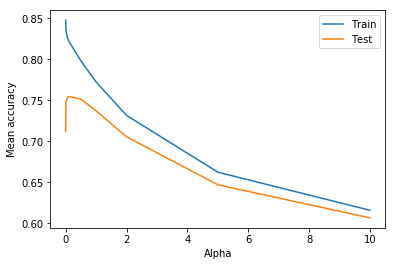

In [10]:
plot_scores(grid_search, 'alpha', 'Alpha', './models/NB/NB-grid-accuracy.png')

### Complement naive bayes

In [11]:
model = ComplementNB()
param_grid = {
    'alpha': [0, 0.01, 0.05,0.1,0.5,1,2,5,10]
}
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=6,
                           scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)

FileNotFoundError: [Errno 2] No such file or directory: './models/CNB/CNB-grid.pk'

In [12]:
pickle.dump(grid_search.cv_results_, open('./models/CNB/CNB-grid.pk', 'wb'))

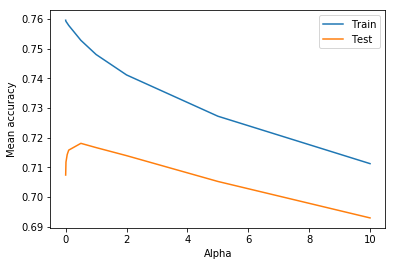

In [13]:
plot_scores(grid_search, 'alpha', 'Alpha', './models/CNB/CNB-grid-accuracy.png')

## Logistic regression

In [14]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
param_grid = {
    'C': [0.05,0.1,0.5,1,2,5,10]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=10, scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)
pickle.dump(grid_search.cv_results_, open('./models/LR/LR-grid.pk', 'wb'))

/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


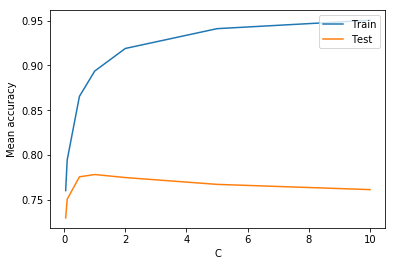

In [15]:
plot_scores(grid_search, 'C', 'C', './models/LR/LR-grid-accuracy.png')

### Logistic regression with OVR

In [16]:
model = LogisticRegression(multi_class='ovr', solver='lbfgs')
model = OneVsRestClassifier(model)
param_grid = {'estimator__C':[0.05,0.1,0.5,1,5,10]}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=10, scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)
pickle.dump(grid_search.cv_results_, open('./models/LR/LR-OVR-grid.pk', 'wb'))

/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


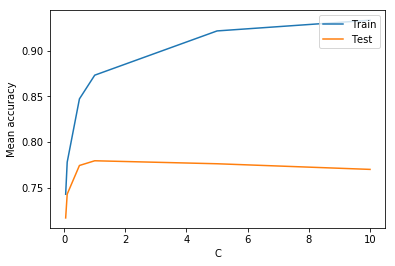

In [17]:
plot_scores(grid_search, 'estimator__C', 'C', './models/LR/LR-OVR-grid-accuracy.png')

### Linear SVC

In [18]:
svc = LinearSVC()
param_grid = {'C':[0.01,0.5,1,5,10,100]}
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=10, scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)
pickle.dump(grid_search.cv_results_, open('./models/LSVC/LSVC-grid.pk', 'wb'))

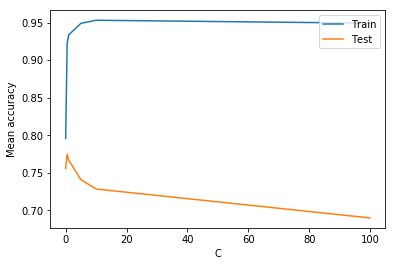

In [19]:
plot_scores(grid_search, 'C', 'C', './models/LSVC/LSVC-grid-accuracy.png')

### SVC

In [26]:
model = SVC()
param_grid = {
    'C':[0.1,0.5,1,5,10],
    'gamma':[0.1, 0.5, 0.75, 1, 2],
    'cache_size':[500]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1,
                           scoring='accuracy')
grid_search.fit(csr_matrix(X), y)
pickle.dump(grid_search.cv_results_, open('./models/SVC/SVC-grid.pk', 'wb'))

### SVC one-vs-rest

In [58]:
svc = SVC()
model = OneVsRestClassifier(svc)
param_grid = {
    'estimator__C':[0.1,0.5,1,5,10],
    'estimator__gamma':[0.1, 0.5, 0.75, 1, 2],
    'estimator__cache_size':[1000]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=6, scoring='accuracy')
grid_search.fit(csc_matrix(X), y)
pickle.dump(grid_search.cv_results_, open('./models/SVC/SVC-OVR-grid.pk', 'wb'))

/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"
/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"
/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil
  warnings.warn("Failed to kill subprocesses on this platform. Please"
/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py:55: UserWarning: Failed to kill 

KeyboardInterrupt: 

Exception in thread QueueManagerThread:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 674, in _queue_management_worker
    recursive_terminate(p)
  File "/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py", line 53, in _recursive_terminate_without_psutil
    _recursive_terminate(process.pid)
  File "/home/ec2-user/.virtualenvs/ds/lib/python3.7/site-packages/joblib/externals/loky/backend/utils.py", line 94, in _recursive_ter

### Compare models

In [29]:
nb = pickle.load(open('./models/NB/NB-grid.pk', 'rb'))
cnb = pickle.load(open('./models/CNB/CNB-grid.pk', 'rb'))
lr = pickle.load(open('./models/LR/LR-grid.pk', 'rb'))
lr_ovr = pickle.load(open('./models/LR/LR-OVR-grid.pk', 'rb'))
lsvc = pickle.load(open('./models/LSVC/LSVC-grid.pk', 'rb'))
svc = pickle.load(open('./models/SVC/SVC-grid.pk', 'rb'))
svc_ovr = pickle.load(open('./models/SVC/SVC-OVR-grid.pk', 'rb'))

/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/model-compare.png
  warn('Filename: {}'.format(filename))


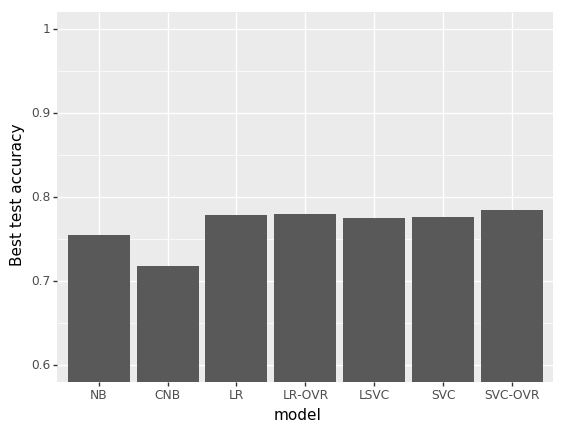

<ggplot: (7545939895)>


In [31]:
scores = [
    nb['mean_test_score'].max(),
    cnb['mean_test_score'].max(),
    lr['mean_test_score'].max(),
    lr_ovr['mean_test_score'].max(),
    lsvc['mean_test_score'].max(),
    svc['mean_test_score'].max(),
    svc_ovr['mean_test_score'].max()]
models = ['NB', 'CNB', 'LR', 'LR-OVR', 'LSVC', 'SVC', 'SVC-OVR']

results = pd.DataFrame({'accuracy': scores, 'model': models})
results['model'] = pd.Categorical(results['model'], categories=models)

p = pn.ggplot(results,pn.aes(y='accuracy', x='model')) + \
    pn.geom_bar(stat = "identity") + \
    pn.ylab('Best test accuracy') + \
    pn.coord_cartesian(ylim=[0.6,1])
p.save('./plots/model-compare.png')
print(p)

# Try some feature engineering

### Apply tf-idf and stemming

In [35]:
from nltk.stem import LancasterStemmer
ls = LancasterStemmer()

In [36]:
def stem(words):
    new_words = []
    
    for word in words:
        word_l = [ls.stem(i) for i in word.split(' ')]
        new_words.append(' '.join(word_l))
        
    return new_words

train_data = json.load(open('data/train.json','r'))

train_as_text = [' '.join(stem(sample['ingredients'])).lower() for sample in train_data]
train_cuisine = [sample['cuisine'] for sample in train_data]

In [37]:
tfidf_enc = TfidfVectorizer(binary=True)
lbl_enc = LabelEncoder()

# X data

X = tfidf_enc.fit_transform(train_as_text)
X = X.astype('float16')

# y labels

y_fit = lbl_enc.fit(train_cuisine)
labels = list(set(train_cuisine))
labels_map = y_fit.transform(np.array(labels))
labels_map = dict(zip(labels_map, labels))

y = y_fit.transform(train_cuisine)

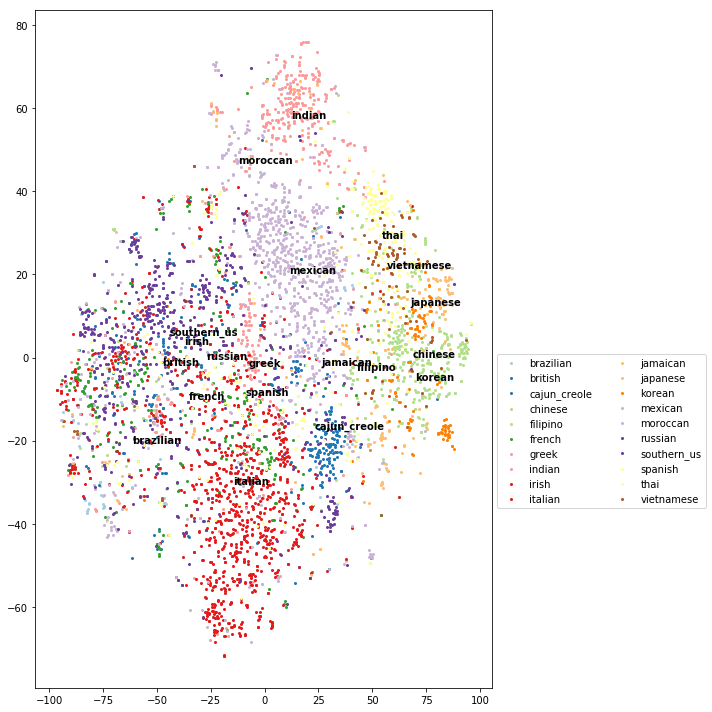

In [52]:
plot_tsne(X[0:5000].astype('float').toarray(), y[0:5000], labels_map, filename='./plots/t-SNE_tfidf_lemm.pdf')

### Naive Bayes

In [43]:
model = MultinomialNB()
param_grid = {
    'alpha': [0, 0.01, 0.05,0.1,0.5,1,2,5,10]
}
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=6,
                           scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=6,
             param_grid={'alpha': [0, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [48]:
pickle.dump(grid_search.cv_results_, open('./models/NB/NB-grid-tfidf-stem.pk', 'wb'))

### Complement NB

In [49]:
model = ComplementNB()
param_grid = {
    'alpha': [0, 0.01, 0.05,0.1,0.5,1,2,5,10]
}
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=6,
                           scoring='accuracy', return_train_score=True)
grid_search.fit(X, y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True,
                                    norm=False),
             iid='warn', n_jobs=6,
             param_grid={'alpha': [0, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [50]:
pickle.dump(grid_search.cv_results_, open('./models/CNB/CNB-grid-tfidf-stem.pk', 'wb'))

### Logistic regression

In [19]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
param_grid = {
    'C': [0.05,0.1,0.5,1,2,5,10]
}
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=4, scoring='accuracy')
grid_search.fit(X, y)
pickle.dump(grid_search, open('./models/LR/LR-grid-tfidf-stem.pk', 'wb'))

/home/ec2-user/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


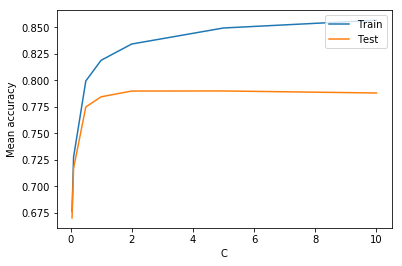

In [25]:
plot_scores(grid_search, 'C', 'C', './models/LR/LR-grid-tfidf-stem-accuracy.png')

### logistic regression with one-vs-all

In [28]:
model = LogisticRegression(multi_class='ovr', solver='lbfgs')
model = OneVsRestClassifier(model)
param_grid = {'estimator__C':[0.05,0.1,0.5,1,5,10]}
grid_search = GridSearchCV(model, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
grid_search.fit(X, y)
pickle.dump(grid_search.cv_results_, open('./models/LR/LR-OVR-grid-tfidf-stem.pk', 'wb'))

/home/ec2-user/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/ec2-user/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/linear_model/log

/home/ec2-user/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


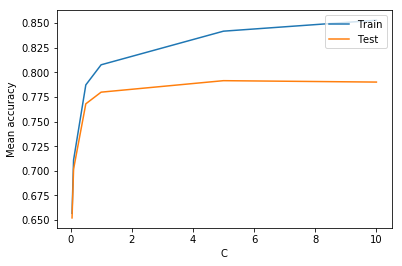

In [29]:
plot_scores(grid_search, 'estimator__C', 'C', './models/LR/LR-OVR-grid-tfidf-stem-accuracy.png')

### linear SVC

In [32]:
svc = LinearSVC()
param_grid = {'C':[0.01,0.5,1,5,10,100]}
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=4, scoring='accuracy')
grid_search.fit(X, y)
pickle.dump(grid_search.cv_results_, open('./models/LSVC/LSVC-grid-tfidf-stem.pk', 'wb'))

/home/ec2-user/anaconda3/envs/mypython3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


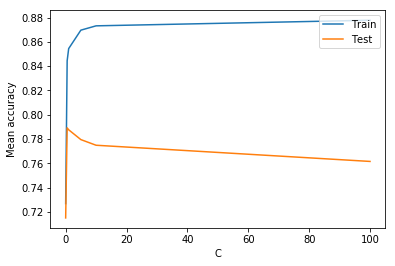

In [33]:
plot_scores(grid_search, 'C', 'C', './models/LSVC/LSVC-grid-tfidf-stem-accuracy.png')

### SVC

In [37]:
model = SVC()
param_grid = {
    'C':[0.1,0.5,1,5,10],
    'gamma':[0.1, 0.5, 0.75, 1, 2],
    'cache_size':[500]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1,
                           scoring='accuracy')
grid_search.fit(X, y)
pickle.dump(grid_search.cv_results_, open('./models/SVC/SVC-grid-tfidf-stem.pk', 'wb'))

### SVC with one-vs-all

In [41]:
svc = SVC()
model = OneVsRestClassifier(svc)
param_grid = {
    'estimator__C':[0.1,0.5,1,5,10],
    'estimator__gamma':[0.1, 0.5, 0.75, 1, 2],
    'estimator__cache_size':[500]
}
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1,
                           scoring='accuracy')
grid_search.fit(X, y)
pickle.dump(grid_search.cv_results_, open('./models/SVC/SVC-OVR-grid-tfidf-stem.pk', 'wb'))

# Compare all models

### load data

In [4]:
# 

nb = pickle.load(open('./models/NB/NB-grid.pk', 'rb'))
cnb = pickle.load(open('./models/CNB/CNB-grid.pk', 'rb'))
lr = pickle.load(open('./models/LR/LR-grid.pk', 'rb'))
lr_ovr = pickle.load(open('./models/LR/LR-OVR-grid.pk', 'rb'))
lsvc = pickle.load(open('./models/LSVC/LSVC-grid.pk', 'rb'))
svc = pickle.load(open('./models/SVC/SVC-grid.pk', 'rb'))
svc_ovr = pickle.load(open('./models/SVC/SVC-OVR-grid.pk', 'rb'))

#

nb2 = pickle.load(open('./models/NB/NB-grid-tfidf-stem.pk', 'rb'))
cnb2 = pickle.load(open('./models/CNB/CNB-grid-tfidf-stem.pk', 'rb'))
lr2 = pickle.load(open('./models/LR/LR-grid-tfidf-stem.pk', 'rb'))
lr_ovr2 = pickle.load(open('./models/LR/LR-OVR-grid-tfidf-stem.pk', 'rb'))
lsvc2 = pickle.load(open('./models/LSVC/LSVC-grid-tfidf-stem.pk', 'rb'))
svc2 = pickle.load(open('./models/SVC/SVC-grid-tfidf-stem.pk', 'rb'))
svc_ovr2 = pickle.load(open('./models/SVC/SVC-OVR-grid-tfidf-stem.pk', 'rb'))

/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/miniconda3/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/model-compare-features.png
  warn('Filename: {}'.format(filename))


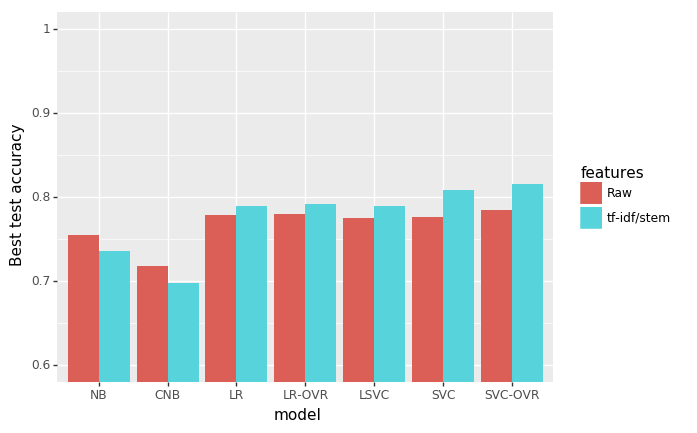

<ggplot: (7546846854)>


In [28]:

scores = [
    nb['mean_test_score'].max(),
    cnb['mean_test_score'].max(),
    lr['mean_test_score'].max(),
    lr_ovr['mean_test_score'].max(),
    lsvc['mean_test_score'].max(),
    svc['mean_test_score'].max(),
    svc_ovr['mean_test_score'].max(),
    nb2['mean_test_score'].max(),
    cnb2['mean_test_score'].max(),
    lr2['mean_test_score'].max(),
    lr_ovr2['mean_test_score'].max(),
    lsvc2['mean_test_score'].max(),
    svc2['mean_test_score'].max(),
    svc_ovr2['mean_test_score'].max()]
features = ['Raw']*7 + ['tf-idf/stem']*7
models = ['NB', 'CNB', 'LR', 'LR-OVR', 'LSVC', 'SVC', 'SVC-OVR']

results = pd.DataFrame({'accuracy': scores, 'features': features, 'model': models*2})
results['features'] = pd.Categorical(results['features'])
results['model'] = pd.Categorical(results['model'], categories=models)

p = pn.ggplot(results,pn.aes(y='accuracy', x='model', fill='features')) + \
    pn.geom_bar(stat = "identity", position='dodge') + \
    pn.ylab('Best test accuracy') + \
    pn.coord_cartesian(ylim=[0.6,1])
p.save('./plots/model-compare-features.png')
print(p)


In [27]:
results

,accuracy,features,model
0,0.754614,Raw,NB
1,0.718107,Raw,CNB
2,0.778247,Raw,LR
3,0.779605,Raw,LR-OVR
4,0.774903,Raw,LSVC
5,0.776965,Raw,SVC
6,0.750000,Raw,SVC-OVR
7,0.735983,tf-idf/stem,NB
8,0.698396,tf-idf/stem,CNB
9,0.790039,tf-idf/stem,LR
